# Modelling a Chemical Reactor Using Machine Learning, Part 2: Improving Process Safety

Richard Kaldenhoven

May 18, 2021

## 1. Introduction

This project is a continuation of "Modelling a Chemical Reactor Using Machine Learning, Part 1: Predicting Product Yield," and deals with how to improve process safety for the same chemical reactor that was considered previously.

Runaway reactions are a serious process safety concern for chemical reactors, and can result in temperatures higher than what the equipment can safely handle. A reactor runaway is caused when exothermic reactions release more heat than what the cooling system can remove, leading to a dangerous increase in temperature in the reactor. Since the rates of reaction increase with temperature, a "runaway" cycle begins where further releases of heat cause increasingly rapid and sharp increases in the reactor temperature.

The focus of this project is to explore what causes a runaway for the reactor considered in Part 1, and develop the concept of a system that can be used to improve process safety. A time series machine learning model will be used to predict if a reactor runaway will occur in the future, based on the current operating conditions. If it is determined that the current operating conditions will cause a reactor runaway in the future, then a "warning system" can be triggered to indicate which process conditions must be changed to avoid a process safety hazard.

## 2. Review of Part 1

From Part 1, the following gas phase, exothermic chemical reactions are considered:

$ (1) \space \space A + 2B \rightarrow C $

$ (2) \space \space 2A + 3C \rightarrow 3D $

The reactions are carried out in a Plug Flow Reactor (PFR) with a co-current cooling water jacket, as shown in the following schematic.

<img src='reactor.jpg' width='800' height='600' />

A review of the dataset generated in Part 1 is given in the following tables. The input process conditions/variables are represented by the `Fao`, `Fbo`, `P`, `To`, `Cto`, `m` and `Ta` columns. The output variables are `T_max` through `Yc`. Recall that the data was generated as real world data was not available, so the data serves as an example to work with and does not represent the operation of an actual reactor.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('reactor_model.csv').drop('Unnamed: 0', axis=1)

In [3]:
df.head()

,Fao,Fbo,P,To,Cto,m,Ta,T_max,Fa_out,Fb_out,Fc_out,Fd_out,Cc_out,Xa,Yc
0,4.663487,11.367418,4.004671,293.275666,0.166524,7.228805,322.440839,503.837106,2.169153,6.380564,2.492066,0.001361,0.021874,0.534865,0.999091
1,4.670153,10.133623,5.147477,308.186556,0.203689,5.364251,331.577689,743.147842,0.000090,1.283669,4.057347,0.367630,0.062470,0.999981,0.868799
2,5.086492,10.287415,5.053539,296.161029,0.208091,8.943619,322.450202,676.397722,0.025824,0.908415,4.132747,0.556753,0.071769,0.994923,0.816640
3,4.732400,8.611231,5.655574,291.278197,0.236785,10.003595,316.771898,689.318257,0.024868,0.485066,3.096409,0.966674,0.080148,0.994745,0.657756
4,5.356279,9.304850,4.633410,293.202364,0.192717,10.781027,331.007534,616.584086,0.282333,0.523259,3.366070,1.024726,0.060586,0.947289,0.663403


In [4]:
df.describe().transpose().apply(lambda s: s.apply('{0:.3f}'.format))

,count,mean,std,min,25%,50%,75%,max
Fao,1000.000,4.984,0.487,3.225,4.672,4.976,5.299,6.877
Fbo,1000.000,10.007,0.977,7.010,9.349,10.047,10.660,12.461
P,1000.000,4.934,0.505,3.234,4.577,4.937,5.280,6.548
To,1000.000,300.075,9.090,267.889,293.963,299.627,306.187,338.560
Cto,1000.000,0.201,0.021,0.127,0.187,0.200,0.215,0.287
m,1000.000,10.087,2.022,3.508,8.736,10.022,11.544,16.711
Ta,1000.000,324.961,9.643,294.683,318.009,325.254,331.386,354.844
T_max,1000.000,646.438,57.051,336.545,614.584,651.448,682.997,819.093
Fa_out,1000.000,0.250,0.578,0.000,0.009,0.056,0.197,5.295
Fb_out,1000.000,1.316,1.133,0.092,0.648,1.004,1.575,9.742


In Part 1, the relationship between the overall yield `Yc` and the input process variables was explored. In order to explore what causes a reactor runaway, the relationship between the input process variables and the maximum reactor temperature `T_max` are examined.

The correlation heatmap from Part 1 can be generated again to show the relationships between variables:

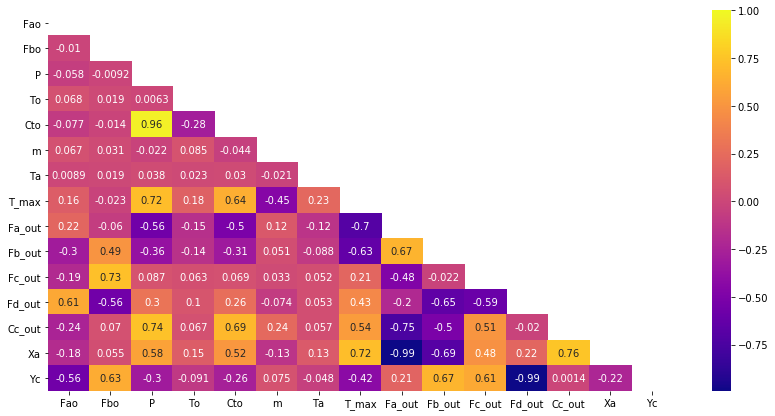

In [5]:
corr = df.corr()
mask = np.triu(corr)

plt.figure(figsize=(14,7))
sns.heatmap(df.corr(), annot = True, cmap='plasma', mask=mask, square=False)

The input process conditions `P`, `Cto`, `m` and `Ta` have the largest correlation coefficients with `T_max`. `P` and `Cto` are correlated with each other almost perfectly, which is why they have a similarily strong effect on `T_max`. Based on knowledge of chemical reaction engineering, the following observations can be made:

* As `P` increases, `Cto` increases. If `Cto` increases, that means there is more of A available to react, which means that more heat will be released, causing `T_max` to increase.
* The flow rate of cooling water `m` is expected to have an influence on the reactor temperature, as it is responsible for removing the heat generated from the reactions. The higher the cooling water flow rate, the more heat will be removed and `T_max` will decrease, as indicated by the negative coefficient.
* The initial cooling water temperature should have an influence on the ability of the water to remove heat from the reactor, as higher `Ta` values mean that there is smaller difference between the temperature of the cooling water and the temperature of the reactor, resulting in less heat transfer.

The following scatterplots show the effects of each input process value on `T_max`. Variables with a higher correlation coefficient will have a higher slope, indicating a stronger relationship. The results are consistent with what is presented in the heatmap.

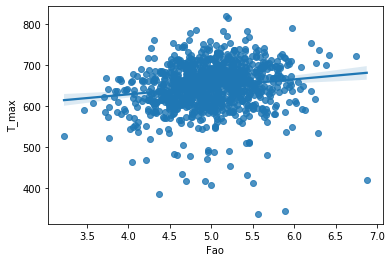

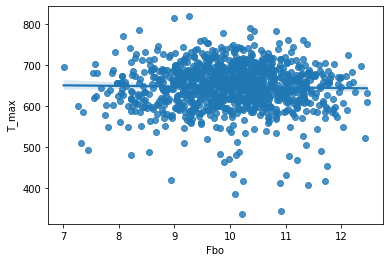

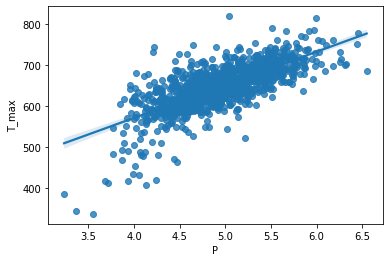

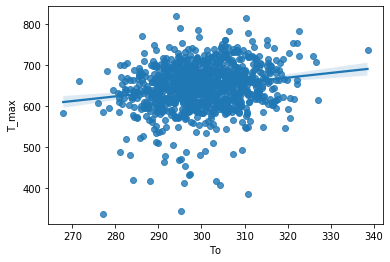

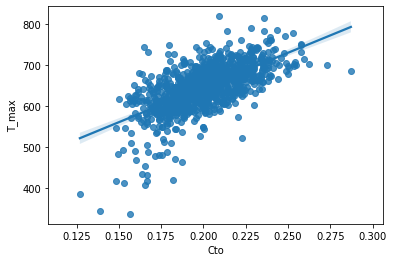

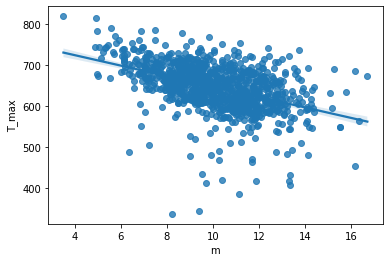

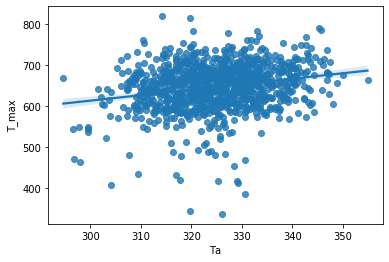

In [6]:
input_value_cols = ['Fao', 'Fbo', 'P', 'To', 'Cto', 'm', 'Ta']
for i, col in enumerate(df[input_value_cols]):
    plt.figure(i)   
    sns.regplot(x=df[col], y=df['T_max'], data=df)  

From the previous graphs it is clear there is a relationship between the input process conditions and `T_max`, and there is potential that changes in these variables could cause a reactor runaway. 

Suppose that the critical temperature (`T_crit`) that cannot safely be exceeded in the reactor is equal to 750 K (477 degC).

In [7]:
T_crit = 750

To determine if a reactor runaway did occur in the dataset from Part 1, the following histogram shows the distribution of `T_max` values:

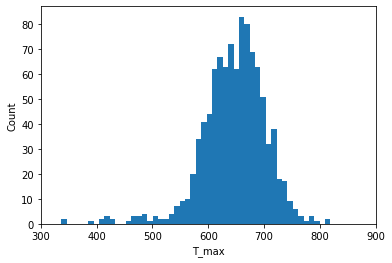

In [8]:
plt.figure()
plt.hist(df['T_max'], bins=50)
plt.ylabel('Count')
plt.xlabel('T_max')
plt.xlim(300, 900);

The histogram shows that `T_crit` has been exceeded several times. The following code counts the number of times, and also expresses the count as a percentage.

In [9]:
print('Total number of samples where T_crit exceeded in df: ', len(df[df['T_max'] >= T_crit]))
print('Percentage of samples where T_crit exceeded in df: ', round(len(df[df['T_max'] >= T_crit])/len(df)*100, 1), '%')

Total number of samples where T_crit exceeded in df:  18
Percentage of samples where T_crit exceeded in df:  1.8 %


The dataset from Part 1 shows that there were 18 samples where the critical reactor temperature was exceeded, as a result of there being enough variation in the input process conditions to cause a reactor runaway.

The critical temperature was exceeded very rarely, at only 1.8% of the total number of samples, but is still a safety hazard that must be avoided. In an effort to avoid a reactor runaway, it is possible to develop a machine learning model that can predict `T_max` in real time, just like the overall yield was predicted in Part 1, and then check that it is below `T_crit`. However, this approach may not provide useful information, as the reactor temperature is likely a process variable that is already monitored in real time anyway.

A potentially more useful application of machine learning would be to forecast what the future value of `T_max` will be, based on the current input process conditions, so that those involved with operating the reactor can receive a warning that `T_crit` will be exceeded. The forecasted value would be far enough in the future that there is enough time to make changes in process conditions so that a reactor runaway is avoided. In order to develop this concept, the dataset from Part 1 will need to be transformed into a time series dataset, as discussed in the following section.

## 3. Generating a Time Series Dataset

A time series dataset will be generated based on the example reactor explained previously. To start, several parameters need to be defined:
* `sample_period` is the time between samples, in this case 10 minutes
* `num_samples_day` is an integer representing the number of samples generated each day
* `num_days` is the number of days that samples will be generated
* `num_samples` is the resulting total number of samples generated.

If a time series dataset for a real reactor was used, each sample would be "collected" rather than "generated."

In [10]:
sample_period = 10
num_samples_day = int(24 * 60 / sample_period)
num_days = 100
num_samples = num_samples_day * num_days

print('Sample period (minutes): ', sample_period)
print('Number of samples per day: ', num_samples_day)
print('Number of days to generate samples: ', num_days)
print('Total number of samples to be generated: ', num_samples)

Sample period (minutes):  10
Number of samples per day:  144
Number of days to generate samples:  100
Total number of samples to be generated:  14400


Functions that were used to generate data in Part 1 are imported here so that they can be reused. For details about these functions, please refer to Part 1.

In [11]:
"""
Import the functions from Part 1:

odes(V, x)
gen_rand_num(mean, std)
generate_data(num_samples, base_dict, lim_dict)

also import:
params dictionary
t_eval array

* function odes has been updated from Part 1 to 
  include exception handling to avoid overflow errors
  in expressions for k2c, k1a
"""

from functions import odes, gen_rand_num, generate_data

In Part 1, two dictionaries `base_dict` and `lim_dict` were used to define the distributions of the input process conditions, and are used again here, with the same values.

`base_dict` stores the inputs from the base operation case, and these values will become the mean of the distribution of randomly drawn numbers.

`lim_dict` stores values representing the fractions of each input that correspond to one standard deviation of the distribution of randomly drawn numbers. For example, one standard deviation of the flowrate Fa is equal to 5 x 0.1 = 0.5. The fractions are chosen to be small to simulate operation that does not vary too much from the baseline (a narrow distribution having a small standard deviation).

In [12]:
base_dict = {'Fa': 5, 'Fb': 10, 'P': 4.92, 'To': 300, 'm': 10, 'Ta': 325}
lim_dict = {'Fa': 0.1, 'Fb': 0.1, 'P': 0.1, 'To': 0.03, 'm': 0.2, 'Ta': 0.03}

The function `generate_time_data` builds upon the `generate_data` function used in Part 1 to create a time series dataset. `num_days`, `num_samples_day`, `base_dict`, and `lim_dict` are passed in as arguments. A random seed (`random_seed`) is used to make sure that the same dataset can be generated again, even though random numbers are involved.

`generate_time_data` works by first creating an empty Pandas DataFrame `df_time`. Then, a for loop is used to repeatedly generate data over `num_days`:
1. The number of samples in each day that result in an increase in `T_max` is defined (`num_inc`), which is based on a random fraction (`rand_frac`) that is generated and multiplied with `num_samples_day`. In this case it is hard coded that at least half of the data generated each day will always result in an increase in `T_max`. The balance of samples each day is made up with `num_dec`, the number of samples resulting in a decrease in `T_max`. The purpose of randomly setting groups of samples that increase or decrease `T_max` is to artificially create a cyclical pattern of variation in `T_max` to make the data that is generated more realistic, which will become clear when the generated data is plotted.

2. The `generate_data` function from Part 1 is used to fill a temporary Pandas DataFrame `temp_df` with `num_inc` samples, according to `base_dict` and `lim_dict`. The samples are sorted in increasing order of `T_max`, and then appended to `df_time`.

3. The `generate_data` function is used again to fill a temporary Pandas DataFrame `temp_df` with `num_dec` samples. The samples are sorted in decreasing order of `T_max`, and then appended to `df_time`.

4. `df_time` is returned.

In [13]:
def generate_time_data(num_days, num_samples_day, base_dict, lim_dict, random_seed=0):

    columns = ['Fao', 'Fbo', 'P', 'To', 'Cto', 'm', 'Ta', 'T_max', 'Fa_out', 'Fb_out', 'Fc_out', 'Fd_out', 'Cc_out', 'Xa', 'Yc']
    df_time = pd.DataFrame(columns = columns)

    np.random.seed(random_seed)
    for i in range(0, num_days):
        rand_frac = float(np.random.uniform(0.5,1,1))
        num_inc = int(num_samples_day * rand_frac)
        num_dec = num_samples_day - num_inc

        temp_data = generate_data(num_inc, base_dict, lim_dict)
        temp_df = pd.DataFrame(data=temp_data, columns=columns)
        temp_df.sort_values('T_max', ascending=True, inplace=True)
        df_time = df_time.append(temp_df, ignore_index=True)

        temp_data = generate_data(num_dec, base_dict, lim_dict)
        temp_df = pd.DataFrame(data=temp_data, columns=columns)
        temp_df.sort_values('T_max', ascending=False, inplace=True)
        df_time = df_time.append(temp_df, ignore_index=True)    

    return df_time

The function `generate_time_data` is executed, storing the results in `df_time`. As expected there are 15 columns as before, but now with 100 days worth of samples (14400 in total) spaced 10 minutes apart.

In [14]:
df_time = generate_time_data(num_days, num_samples_day, base_dict, lim_dict, random_seed=10)
print('df_time DataFrame shape: ', df_time.shape)

df_time DataFrame shape:  (14400, 15)


A preview of the dataset is given below:

In [15]:
df_time.to_csv('reactor_model_time.csv')

In [16]:
df_time.head()

,Fao,Fbo,P,To,Cto,m,Ta,T_max,Fa_out,Fb_out,Fc_out,Fd_out,Cc_out,Xa,Yc
0,5.086776,9.815115,3.776197,289.890340,0.158857,9.759539,330.942724,435.929962,3.335700,6.313287,1.750671,0.000243,0.016223,0.344241,0.999769
1,4.966548,9.759046,4.030505,286.294514,0.171685,6.678898,320.557860,497.707818,2.699724,5.227839,2.263772,0.001831,0.021933,0.456418,0.998654
2,5.216480,9.995507,4.002557,294.530467,0.165727,15.238250,331.470031,512.504622,2.057154,3.695158,3.136447,0.013727,0.033555,0.605643,0.992758
3,4.981942,9.745565,4.235600,283.337102,0.182305,10.805347,319.593217,519.562014,2.127068,4.048004,2.839640,0.009140,0.031285,0.573044,0.994664
4,4.778465,9.032919,4.414747,291.639480,0.184606,15.260116,313.836636,521.806726,1.168840,1.933051,3.460397,0.089537,0.053674,0.755394,0.958658


Note that there is no column for the time and date that each sample was collected. Since the samples represent random changes in the input process variables, there is no pattern between the time and `T_max`, so in this case the time is not a useful feature to predict `T_max`. When considering time series data for a real reactor, the time and date may be important, if there are regular step changes or cyclical changes that occur in the variables, for example.

The following code counts the number of times that `T_crit` is exceeded. It appears that 2.1% of samples exceed `T_crit`, a similar percentage of samples as in the dataset from Part 1 (1.8%), indicating that the time series dataset represents similar information as in Part 1.

In [17]:
T_above_indices = df_time[df_time['T_max'] > T_crit].index.tolist()
print('Total number of samples where T_crit exceeded in df_time: ', len(T_above_indices))
print('Percentage of samples where T_crit exceeded in df_time: ', round(len(T_above_indices)/len(df_time)*100, 1), '%')
print('\n')

T_above_firstday = [x for x in T_above_indices if x <= num_samples_day]
print('Number of samples where T_crit exceeded in first day: ', len(T_above_firstday))
print('Percentage of samples where T_crit exceeded in first day: ', round(len(T_above_firstday)/num_samples_day*100, 1), '%')
print('Indices: ', T_above_firstday)

Total number of samples where T_crit exceeded in df_time:  306
Percentage of samples where T_crit exceeded in df_time:  2.1 %


Number of samples where T_crit exceeded in first day:  3
Percentage of samples where T_crit exceeded in first day:  2.1 %
Indices:  [124, 125, 126]


The following function `plot_time_series` plots the time series values for `T_max` and the input process variables `P`, `m` and `Ta`, which are chosen since they have the strongest correlation with `T_max`. `P` is chosen instead of `Cto` since they are already correlated and the pressure is likely a variable that is monitored in real life, as are the cooling water flow rate and intial temperature.

The value for `T_crit`, and the average values for each process variable are also plotted as horizontal lines. Samples where `T_max` exceeds `T_crit` are identified as purple vertical lines across all plots, to help identify which process variables are causing the increase in `T_max`. Note that since there is no time column in the data, the x-axis becomes the "Sample Number", and the data is interpreted as having consecutive samples spaced 10 minutes apart.

In [18]:
def plot_time_series(data, start, stop, step, indices, T_crit):
    data = data[:stop]

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(12, 10))

    ax1.plot(data['T_max'])
    ax1.hlines(y=T_crit, xmin=0, xmax=stop, colors='r', label='T crit')
    ax1.hlines(y=data['T_max'].mean(), xmin=0, xmax=stop, colors='g', linestyle='dashed', linewidth=3, label='T Avg', zorder=5)
    ax1.set(ylabel = 'T_max')
    ax1.grid()
    ax1.set_xlim(start,stop)
    ax1.set_xticks(np.arange(start, stop, step))
    ax1.legend(loc='lower right')

    ax2.plot(data['P'])
    ax2.set(ylabel = 'P')
    ax2.grid()
    ax2.hlines(y=data['P'].mean(), xmin=0, xmax=stop, colors='g', linestyle='dashed', linewidth=3, label='P Avg', zorder=5)
    ax2.legend(loc='lower right')
    
    ax3.plot(data['m'])
    ax3.set(ylabel = 'm')
    ax3.grid()
    ax3.hlines(y=data['m'].mean(), xmin=0, xmax=stop, colors='g', linestyle='dashed', linewidth=3, label='m Avg', zorder=5)
    ax3.legend(loc='lower right')    
    
    ax4.plot(data['Ta'])
    ax4.set(ylabel = 'Ta')
    ax4.grid()
    ax4.hlines(y=data['Ta'].mean(), xmin=0, xmax=stop, colors='g', linestyle='dashed', linewidth=3, label='Ta Avg', zorder=5)
    ax4.legend(loc='lower right')
    
    plt.xlabel('Sample Number')

    for i, ax in enumerate((ax1, ax2, ax3, ax4)):
        for j in indices:
            ax.axvline(x=j, color='m')

The first 10 days of the time series data are plotted, where the cyclical change in variables can be observed. By examining the samples leading up to the ones indicated by purple lines, the cause of the reactor runaways can be determined. As expected from analysis of the data in Section 2, increases in `T_max` are caused by simultaneous increases in `P` and decreases in `m`. To a lesser extent, increases in `T_max` are caused by increases in `Ta`, which does not vary from the mean as much as `P` or `m`. 

The practical interpretation of these trends in variables is that as `P` increases, more of chemical A is fed to the reactor, which increases the amount of heat released, since the reactions are exothermic. At the same time, the cooling water flowrate `m` is decreasing, meaning that less heat is removed from the reactor, which causes `T_max` to increase gradually until it exceeds `T_crit`.

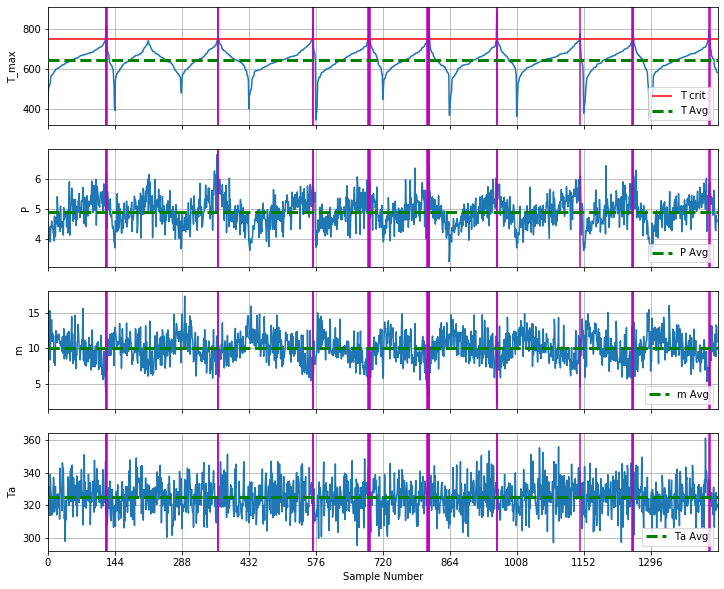

In [19]:
plot_time_series(data=df_time, start=0, stop=10*num_samples_day, step=num_samples_day, indices=T_above_indices, T_crit=T_crit)

Data for the first day is also plotted below, showing a closer view of the changes in variables with time. From the plot it can be seen how the data that is generated simulates a reactor runaway that slowly occurs over the course of a day. `T_max` finally rises above `T_crit` due to sudden rises in `P` and `Ta`, along with a drop in `m`.

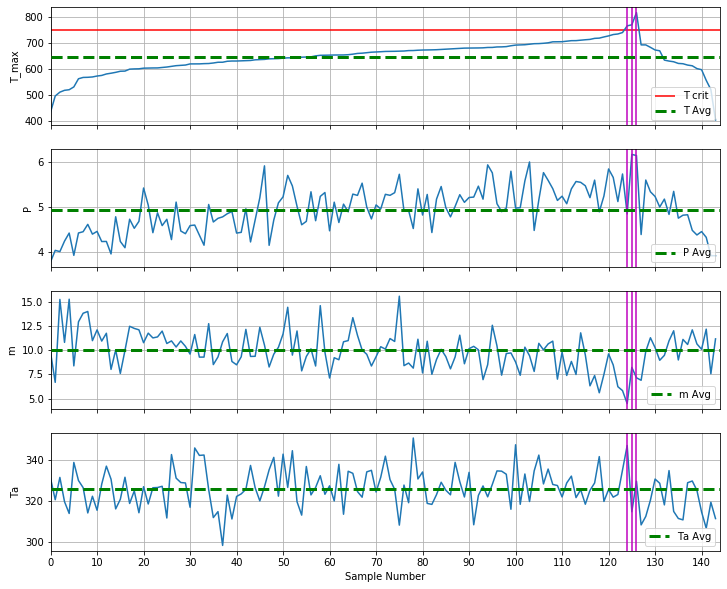

In [20]:
plot_time_series(data=df_time, start=0, stop=num_samples_day, step=sample_period, indices=T_above_firstday, T_crit=T_crit)

It is important to note that the time series data that has been generated is not entirely realistic, for a couple of reasons. A reactor runaway is an event that should never happen, so data representing the event would not be available.  Also, even though the number of samples where `T_crit` is exceeded is very small, there is still a reactor runaway occuring each day. Despite these inaccuracies, sudden drops in the cooling water flow rate `m` as shown in the data are possible, and simulate a cooling system failure in real life, an event that can lead to a reactor runaway. Increases in the feed to the reactor and a resulting increase in `P` have led to reactor runaways in real life, due to there being excessive amounts of heat released from adding large amounts of reactant chemicals that cannot be removed by the cooling system.

Although the data that has been generated is not perfect, it does represent phenomena that is consistent with the theory behind chemical reaction engineering. In the following sections, a machine learning model will be developed and its performance will be evaluated to see how accurately it can predict when a reactor runaway will occur.

## 4. Machine Learning Problem Definition

In order to predict whether a reactor runaway will occur in the future, the value of `T_max` will be forecasted based on the patterns present in data from the past, and so this problem is a form of time series regression. The data from the past will contain the following features from the generated time series data, representing the input process variables: `Fao`, `Fbo`, `P`, `To`, `Cto`, `m` and `Ta`. The target variable to predict is `T_max`.

## 5. Model Evaluation Protocol

The time series data generated in Section 3 will be split into train, validation and test sets in a 70/20/10% ratio. Two types of machine learning models will be developed to compare results: a more basic Random Forest model, and a deep learning model. The deep learning model will make use of the validation set to develop the neural network architecture.

Once a model is fitted on the training set, its performance will be evaluated based on the Mean Absolute Error (MAE) between the predicted value of `T_max` and the true value, based on the test set.

## 6. Developing a Machine Learning Model

To set a baseline for machine learning model performance, a Random Forest model will be developed, and then a Deep Learning model will be developed to compare results, as discussed in the following sections.

### 6.1 Basic Model

Prior to developing a Random Forest Model, there are several data preparation steps that are required, which are described below.

#### 6.1.1 Data Preparation

First, unnecessary columns from the time series data generated in Section 3 can be removed.

In [21]:
drop_columns = ['Fa_out', 'Fb_out', 'Fc_out', 'Fd_out', 'Cc_out', 'Xa', 'Yc']

df_base = df_time.copy()
df_base.drop(drop_columns, axis=1, inplace=True)
df_base.head()

,Fao,Fbo,P,To,Cto,m,Ta,T_max
0,5.086776,9.815115,3.776197,289.890340,0.158857,9.759539,330.942724,435.929962
1,4.966548,9.759046,4.030505,286.294514,0.171685,6.678898,320.557860,497.707818
2,5.216480,9.995507,4.002557,294.530467,0.165727,15.238250,331.470031,512.504622
3,4.981942,9.745565,4.235600,283.337102,0.182305,10.805347,319.593217,519.562014
4,4.778465,9.032919,4.414747,291.639480,0.184606,15.260116,313.836636,521.806726


Next, the train/validation/test split of the data is performed:

In [22]:
num_train_samples = int(0.7 * num_samples)
num_val_samples = int(0.2 * num_samples)
num_test_samples = num_samples - num_train_samples - num_val_samples

print('num_samples: ', num_samples)
print('num_train_samples: ', num_train_samples)
print('num_val_samples: ', num_val_samples)
print('num_test_samples: ', num_test_samples)

df_train = df_base[:num_train_samples]
df_val = df_base[num_train_samples: num_train_samples + num_val_samples]
df_test = df_base[num_train_samples + num_val_samples:]

print('\n')
print('length df_train: ', len(df_train))
print('length df_val: ', len(df_val))
print('length df_test: ', len(df_test))

num_samples:  14400
num_train_samples:  10080
num_val_samples:  2880
num_test_samples:  1440


length df_train:  10080
length df_val:  2880
length df_test:  1440


In order to make a prediction for the future value of `T_max` based on data from the past, the time series data needs to be reformatted. In a typical machine learning problem, the features and target form a pair that correspond with one another, for example a set of feature values correspond with a certain target value. Since the machine learning problem is a time series regression, the feature values of the data are in the past and the target is in the future, so a slightly different type of feature/target pair is used where past feature values correspond to a target value in the future.

To reformat the data, it is necessary to define the number of past data samples that are used to make a prediction (`input_length`) and the number of steps in the future at which `T_max` will be predicted. For example, an `input_length` equal to 6 means that the past 6 samples will be used to predict the future temperature, and since samples are spaced 10 minutes apart, a total of 60 minutes (1 hour) of past data will be considered. An `offset` equal to 1 means that the value of `T_max` will be predicted one step, or 10 minutes, in the future.


In [23]:
input_length = 6
offset = 1

In a practical application `input_length` and `offset` should be chosen based on knowledge of the process dynamics. The `input_length` should be large enough to capture variation in the process, and the `offset` should be far enough in the future that there is sufficient time to adjust process conditions should a reactor runaway be forecasted. Some experimentation may be helpful to quantify the tradeoff between `offset` and the model MAE, as increasing the offset may mean that the future value of `T_max` is harder to predict. Increasing the `input_length` may also be helpful, if it captures more data that can aid in prediction.

The following function `series_to_sequences` reformats the time series data so that the feature values for each sample correspond with a future value for `T_max`, which is achieved by shifting the values in the `T_max` column "up" or backwards in time by an amount equal to the sum of `input_length` and `offset`.

In [24]:
def series_to_sequences(dataframe, column, input_length, offset):
    df_shift = dataframe.copy()
    periods = -1 * (input_length + offset)
    
    shifted_col_name = column + ' shift'
    df_shift[shifted_col_name] = df_shift[column].shift(periods=periods, axis=0)
    df_shift.dropna(axis=0, inplace=True)

    return df_shift

`series_to_sequences` is then executed on the train, validation, and test sets:

In [25]:
df_train_shift = series_to_sequences(df_train, 'T_max', input_length, offset)
df_val_shift = series_to_sequences(df_val, 'T_max', input_length, offset)
df_test_shift = series_to_sequences(df_test, 'T_max', input_length, offset)

print('df_train_shift shape: ', df_train_shift.shape)
print('df_val_shift shape: ', df_val_shift.shape)
print('df_test_shift shape: ', df_test_shift.shape)

df_train_shift shape:  (10073, 9)
df_val_shift shape:  (2873, 9)
df_test_shift shape:  (1433, 9)


Note that the datasets now contain fewer samples. Since `series_to_sequences` shifts the `T_max` columns values up, the final rows will not contain values for `T_max`, so they are deleted. In this case, `input_length` + `offset` rows are deleted, equal to the amount that the data was shifted. To illustrate the effects of reformatting the data, a preview of the reformatted training set can be considered:

In [26]:
df_train_shift.head(10)

,Fao,Fbo,P,To,Cto,m,Ta,T_max,T_max shift
0,5.086776,9.815115,3.776197,289.890340,0.158857,9.759539,330.942724,435.929962,569.067717
1,4.966548,9.759046,4.030505,286.294514,0.171685,6.678898,320.557860,497.707818,569.600788
2,5.216480,9.995507,4.002557,294.530467,0.165727,15.238250,331.470031,512.504622,570.927208
3,4.981942,9.745565,4.235600,283.337102,0.182305,10.805347,319.593217,519.562014,574.487215
4,4.778465,9.032919,4.414747,291.639480,0.184606,15.260116,313.836636,521.806726,576.817041
5,5.657862,10.693108,3.919462,288.467496,0.165697,8.377974,338.810735,532.567421,582.422583
6,4.653452,9.424654,4.416218,287.092422,0.187592,12.927508,329.949541,563.961571,585.285067
7,5.237722,9.067885,4.444463,307.089428,0.176498,13.809394,326.477980,569.067717,588.652645
8,4.824849,9.010350,4.607947,317.088860,0.177220,13.993046,314.092953,569.600788,592.876862
9,4.336513,8.802253,4.390738,289.702503,0.184830,10.981263,322.254111,570.927208,593.467939


The sample at index 0 formerly had `T_max` = 435.929, and after shifting `T_max shift` = 569.067, the value from index 7.

The final data preparation step is to form `X`/`y` pairs of data for use in a machine learning model:

In [27]:
X_train = df_train_shift.drop(['T_max', 'T_max shift'], axis=1)
y_train = df_train_shift['T_max shift']

X_test = df_test_shift.drop(['T_max', 'T_max shift'], axis=1)
y_test = df_test_shift['T_max shift']

#### 6.1.2 Model Development

The following code builds a Random Forest model:

In [28]:
from sklearn.ensemble import RandomForestRegressor
rfm = RandomForestRegressor(random_state=0)

rfm.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [29]:
y_pred = rfm.predict(X_test)

from sklearn.metrics import mean_absolute_error

rfm_mae = mean_absolute_error(y_test, y_pred)
print('Random Forest Model MAE (K): ', round(rfm_mae, 3))

Random Forest Model MAE (K):  23.923


After fitting the model, the MAE on the test set is 23.923 K (also 23.923 C), which is quite a large error for a safety application. There is likely room for improvement, which is discussed when developing a Deep Learning model in the next section.

### 6.2 Deep Learning Model

In this section a deep learning model is developed to try and achieve an improvement (lower MAE) over the Random Forest baseline model. A time series regression machine learning problem can be solved using deep learning by using neural networks developed to work with time series data, also known as sequence models, so there are some further data preparation steps required before moving on to developing the network.

#### 6.2.1 Data Preparation

The data that will be used for the deep learning model is the same time series data as before, prior to being reformatted with the `series_to_sequences` function. The data is first standardized by subtracting the mean and dividing by the standard deviation:

In [30]:
df_train_mean = df_train.mean()
df_train_std = df_train.std()

df_train_norm = (df_train - df_train_mean) / df_train_std
df_val_norm = (df_val - df_train_mean) / df_train_std
df_test_norm = (df_test - df_train_mean) / df_train_std

Values are taken out of Pandas DataFrames and stored in Numpy arrays:

In [31]:
train_data = df_train_norm.values
val_data = df_val_norm.values
test_data = df_test_norm.values

The function `sequence_generator` works in essentially the same way as the `series_to_sequences` function, the difference being that it returns pairs of `samples` (the feature values) and `targets` (`T_max` values) in batches, as defined with the `batch_size` argument. The same `input_length` and `offset` parameters defined previously are used again. `sequence_generator` is a generator function, meaning that it will generate batches of data in an endless loop, so it will become necessary to define the number of steps that the function will loop through to work through an entire dataset.

In [32]:
def sequence_generator(data, input_length, offset, batch_size):
    max_index = len(data)
    min_index = 0
    
    i = min_index + input_length
    
    while True:
        if i + batch_size >= max_index:
            i = min_index + input_length
            
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)
        
        # samples shape (number of samples per batch, input length, number of features)
        samples = np.zeros((len(rows), input_length, data.shape[-1]))
        # targets shape (number of samples per batch, )
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - input_length, rows[j], 1)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + offset][-1] # -1 is index for 'T_max' column
    
        yield samples, targets

The following code sets the batch size and creates three generators for the train, validation and test sets:

In [33]:
batch_size = 32

train_gen = sequence_generator(data=train_data, 
                           input_length=input_length, 
                           offset=offset, 
                           batch_size=batch_size)

val_gen = sequence_generator(data=val_data, 
                         input_length=input_length, 
                         offset=offset, 
                         batch_size=batch_size)

test_gen = sequence_generator(data=test_data, 
                          input_length=input_length, 
                          offset=offset, 
                          batch_size=batch_size)

val_steps = (num_val_samples - input_length) // batch_size
test_steps = (num_test_samples - input_length) // batch_size

In order for the generator function to make a complete pass through the validation and test sets, the following number of steps are required:

In [34]:
print('val_steps: ', val_steps)
print('test_steps: ', test_steps)

val_steps:  89
test_steps:  44


#### 6.2.2 Model Development

With data preparation complete, it is possible to develop a deep learning model. To train a model, the following number  of steps must be taken with the training data generator function to make a complete pass through the dataset:

In [35]:
steps_per_epoch = (num_train_samples - input_length) // batch_size
print('steps_per_epoch = ', steps_per_epoch)

steps_per_epoch =  314


A neural network with a single layer using Long Short Term Memory (LSTM) units is created using the Keras deep learning framework:

In [113]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.LSTM(16, activation='relu', input_shape=(input_length, train_data.shape[-1])))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,617
Trainable params: 1,617
Non-trainable params: 0
_________________________________________________________________


The model is compiled and trained:

In [114]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(train_gen, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=40, 
                    validation_data=val_gen, 
                    validation_steps=val_steps,
                    verbose=0)

In [115]:
model.save('model.h5')

The model training history is plotted using the imported convenience function `create_val_plot`:

In [116]:
from create_val_plot import create_val_plot

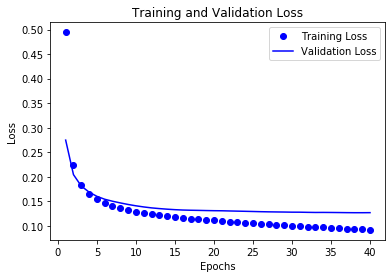

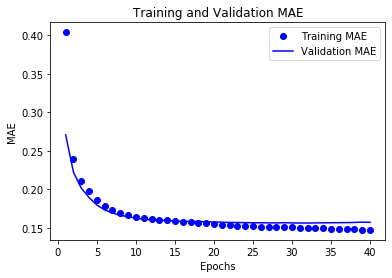

In [117]:
create_val_plot(history)

In [118]:
model_metrics = model.evaluate(val_gen, batch_size=batch_size, steps=val_steps)
model_mae = model_metrics[1]
print('Validation MAE: ', round(model_mae, 3))

89/89 [==============================] - 0s 3ms/step - loss: 0.1267 - mae: 0.1571
Validation MAE:  0.157


In [119]:
test_metrics = model.evaluate(test_gen, batch_size=batch_size, steps=test_steps)
test_mae = test_metrics[1]
print('Test MAE: ', round(test_mae, 3))

44/44 [==============================] - 0s 3ms/step - loss: 0.1099 - mae: 0.1441
Test MAE:  0.144


The MAE on the test set is slightly lower than the validation set, so the model is able to generalize to new data. Experimentation using more or less LSTM units, as well as dropout and regularization did not yield significant improvements in the MAE.

The MAE values are in units of standardized Kelvin, and can be converted back to Kelvin by multiplying by the standard deviation.

In [120]:
print('Deep Learning Model MAE (K): ', round(test_mae * df_train_std[-1], 3))

Deep Learning Model MAE (K):  8.914


The deep learning model has a MAE of around 9 K (9 C), which is a large improvement compared to the baseline Random Forest model, however is still large for a safety application. To put the MAE score in perspective, it is achieved by training on only about 10000 samples, a relatively small number for deep learning.

## 7. Using the Machine Learning Model in Practice

In this section, the concept of a reactor runaway "warning system" will be developed that incorporates the machine learning model from the previous section. The machine learning model allows predictions to be made for the maximum reactor temperature `T_max`, so if the predicted value is greater than or equal to the maximum safe temperature `T_crit`, a warning can be triggered for those involved with operating the reactor so that changes can be made to the input process conditions to avoid a process safety hazard. 

The success of such a system depends on the accuracy of the machine learning model, and from the previous section it is known that the MAE is approximately 9 degrees K, which is a large error for a safety application. To mitigate the error in the machine learning model a threshold is defined that lowers `T_crit` by an amount larger than the model MAE, in this case 10 degrees, so that if a prediction is made in error, on average it will still be below the true value of `T_crit` (750 K).

The following code defines the threshold and the resulting new maximum safe temperature `T_crit_new`, which must be normalized in the same way as in Section 6.2.1.

In [121]:
threshold = 10
T_max_mean = df_train_mean[-1]
T_max_std = df_train_std[-1]

T_crit_new = T_crit - threshold
T_crit_st = (T_crit_new - T_max_mean) / T_max_std

print('T_crit_new (K): ', T_crit_new)
print('T_crit_st: ', round(T_crit_st, 3))

T_crit_new (K):  740
T_crit_st:  1.534


Next, some baseline values for the input process conditions are defined with `base_input_values`.

In [122]:
base_input_values = df.mean()[input_value_cols].values

To show how the concept of a reactor runaway "warning system" could be implemented, the test data set will be used as an example. The code below counts the number of times that `T_max` exceeds `T_crit_new`.

In [123]:
len(df_test[df_test['T_max'] >= T_crit_new])

50

Next, the sample numbers that correspond to every instance where `T_max` exceeds `T_crit_new` are determined:

In [124]:
df_test[df_test['T_max'] >= T_crit_new].index.values - df_test.index.values[0]

array([ 117,  118,  119,  231,  232,  233,  234,  235,  366,  367,  368,
        369,  370,  554,  555,  556,  665,  666,  667,  668,  669,  670,
        671,  672,  673,  674,  675,  817,  818,  819,  937,  938,  939,
        940,  941,  942,  943, 1134, 1135, 1136, 1137, 1138, 1139, 1140,
       1141, 1286, 1287, 1393, 1394, 1395], dtype=int64)

Recall from the plots of the time series data in Section 3 that a reactor runaway consists of `T_max` exceeding `T_crit`, after which it rapidly peaks and then eventually decreases back to a safe temperature. From the array of sample numbers above it can be seen that runaways occur periodically in groups where `T_max` exceeds `T_crit_new`, so the start of a runaway can be signified with the first sample. For example, the first runaway in the test set starts with sample number 117, the second with sample number 231, the third with sample number 366, and so on. In total there are 10 runaways for the warning system to detect.

The warning system will be successful if it can correctly identify each of these sample numbers as the start of a runaway, based on a prediction for `T_max` that is made with the machine learning model. The following code performs several steps:
1. Loop through the test dataset `test_steps` times, using `test_gen` to generate batches of samples and targets as in Section 6.
2. Use the deep learning model from Section 6 to make predictions for `T_max` on each batch of `samples`.
3. Loop through the `predictions` for each batch of `samples`, and if a value is greater than or equal to `T_crit_st` (the normalized `T_crit_new`) then append the index to `index_list` to keep track of the samples that have been predicted to be part of a reactor runaway.
4. If a reactor runaway has been predicted, `index_list` will contain values (length greater than 0). The minimum value signifies the start of a runaway and is stored as `runaway_start`. The batch number, batch index, and sample number are printed out so that the results can be checked against the sample numbers determined previously.
5. A warning message is printed with the predicted `T_max` corresponding to `runaway_start` and the amount of time in the future that the prediction has been made (the `offset` from the data preparation sections).
6. The current operating conditions are compared against the baseline values for the input process conditions by calculating `delta`, to show which variable(s) are going to cause a reactor runaway. Both sets of values are printed.

As a second way to check if the warning system is working correctly, a counter variable (`count`) is used to keep track of the number of times a warning is displayed. Since the machine learning model is not 100% accurate, the sample numbers found and the count may not be exactly equal to the values above but they should be very close.

The following code creates a warning system that runs through the test data set:


In [207]:
count = 0

for i in range(0, test_steps):
        
    samples, targets = next(test_gen)
    predictions = model.predict(samples)
    
    index_list = []
    
    for j in range(0, predictions.shape[0]):  
        
        if predictions[j] >= T_crit_st:
            count += 1
            index_list.append(j)
        
    if len(index_list) > 0:
            
        runaway_start = min(index_list)
        sample_number = runaway_start + i * batch_size + input_length
        
        predicted_value = int(predictions[runaway_start] * T_max_std + T_max_mean)
        
        print('Batch ' + str(i+1) + ' / Batch Index ' + str(runaway_start) + ' / Sample Number ' + str(sample_number)  + '\n')
        print('Warning! Reactor Runaway Predicted in ' + str(offset * sample_period) + ' minutes')
        print('Max Reactor Temp predicted to be '+ str(predicted_value) + ' K')
        print('Maximum Safe Reactor Temp is ' + str(T_crit_new) + ' K')
        
        current_values = samples[runaway_start][-1][:-1]
        current_values = current_values * df_train_std[:-1] + df_train_mean[:-1]
        delta = current_values - base_input_values
        results = {'Variable':input_value_cols, 'Baseline Value':base_input_values, 'Current Value': current_values, 'Delta':delta} 
        df_results = pd.DataFrame(results)
        df_results.set_index('Variable', inplace=True)
        
        print('\nCurrent Reactor Input Conditions:')
        print(df_results.apply(lambda s: s.apply('{0:.3f}'.format)))
        print('----------------------------------------------')

Batch 4 / Batch Index 15 / Sample Number 117

Warning! Reactor Runaway Predicted in 10 minutes
Max Reactor Temp predicted to be 740 K
Maximum Safe Reactor Temp is 740 K

Current Reactor Input Conditions:
         Baseline Value Current Value   Delta
Variable                                     
Fao               4.984         5.082   0.098
Fbo              10.007        11.207   1.200
P                 4.934         5.014   0.079
To              300.075       290.706  -9.369
Cto               0.201         0.210   0.010
m                10.087         5.348  -4.739
Ta              324.961       340.462  15.501
----------------------------------------------
Batch 8 / Batch Index 1 / Sample Number 231

Warning! Reactor Runaway Predicted in 10 minutes
Max Reactor Temp predicted to be 740 K
Maximum Safe Reactor Temp is 740 K

Current Reactor Input Conditions:
         Baseline Value Current Value   Delta
Variable                                     
Fao               4.984         4.641  -

In [208]:
print('Number of times T_crit_new exceeded: ', count)

Number of times T_crit_new exceeded:  51


The warning system detected 51 values where `T_max` exceeded `T_crit_new`, compared to the 50 values present in the test set, so the system appears to be functioning correctly. There are 10 reactor runaways for the warning system to detect, and the above results show that 11 were predicted: 
* 5 on time (sample numbers 117, 231, 817, 937, 1286)
* 4 early (sample numbers 367, 550, 664, with an extra prediction at 1284) 
* 2 late (367, 1394, both late by 1 sample or 10 minutes)

On time and early predictions would result in preventing a reactor runaway, while the 2 late predictions may not provide enough of a warning to avoid a safety hazard. The error rate of the warning system on the test data set is considered to be 2 late predictions / 10 runaways, or 20%. In other words, use of the reactor runaway warning system would have helped avoid 80% of the reactor runaways present in the test data set.

## 8. Conclusions

The dataset used in "Modelling a Chemical Reactor Using Machine Learning, Part 1: Predicting Product Yield" has been explored, and it has been determined that of the input process variables, the pressure, cooling water flowrate and initial cooling water temperature are the three strongest predictors of a reactor runaway. The dataset has been converted to a time series format in order to develop a machine learning model that is used to predict the reactor temperature in the future, based on the current operating conditions.

Using deep learning, a model has been developed with a Mean Absolute Error (MAE) of approximately 9 degrees C. Although the MAE of the machine learning model is relatively poor for a safety application, the error has been mitigated by introducing a 10 degree C threshold that lowers the maximum safe reactor temperature, so that on average the model will still predict values lower than what the reactor equipment can safely handle. The model is incorporated into a warning system that could alert those involved with operating the reactor when the current operating conditions will cause a reactor runaway in the future. The advantage of a time series model is that it allows for enough time to be given so that corrective action can be taken to avoid a reactor runaway and a process safety hazard. 

The warning system that has been developed correctly predicted reactor runaways 80% of the time on the test dataset, improving process safety. Although not perfect, the results are promising and further efforts to develop the concept of a reactor runaway warning system with increased performance would be worthwhile.



## 9. Recommendations

In order to apply the concepts presented in this project to a real world application, it is recommended to gather operating data for the chemical reactor being considered and determine if it is possible to model the relationship between the process variables and the reactor temperature. If it is possible to build a model, then the model must have high enough prediction accuracy to act as a trigger for a warning system. When gathering time series data, consideration for the process dynamics should be made so that the amount of past data considered and the amount of time in the future that predictions are made make sense for the application.

In this project, a relatively small amount of data (about 10000 samples) has been used, and when using deep learning it is possible that training a model with more data will improve the results. It is almost certain that no data exists that represents when the reactor temperature reaches an unsafe value. There are a couple of approaches that may be worth exploring to address the lack of data representing reactor runaways. The first is to use an analytical model of the reactor in a similar way as in this project to artificially create data representing a reactor runaway, as a form of data augmentation or oversampling. The second is to use a threshold, as demonstrated in the warning system, so that the maximum safe temperature in the reactor is lowered to a value that is easier to predict accurately with a machine learning model.